# Movie Genre Prediction

In [15]:
import zipfile
import pandas as pd
import numpy as np
import json
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, multilabel_confusion_matrix
from sklearn.pipeline import Pipeline
import joblib
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import text_processing as tp

### Purpose of script
This script uses the "The Movies Dataset" dataset to train a model that predicts a movie's genre given its title and description.
https://www.kaggle.com/rounakbanik/the-movies-dataset?select=movies_metadata.csv <br>

To retrain the model and reproduce the analysis, download and save the dataset in the data folder.

### Extract data

If you haven't already unzipped the downloaded file run the cell below to unzip.

In [2]:
MOVIE_DATA_DIR = './data/archive.zip'
TARGET_DIR = './data/'

# Check if zip file exists and extract if it does
try:
    with open(MOVIE_DATA_DIR) as f:
        with zipfile.ZipFile(MOVIE_DATA_DIR, 'r') as zip_ref:
            zip_ref.extractall(TARGET_DIR)
except IOError:
    print("File not accessible")

### Load Data

In [3]:
MOVIE_DATA_DIR = './data/movies_metadata.csv'

# Load the data into a DataFrame
raw_data = pd.read_csv(MOVIE_DATA_DIR, sep=',', error_bad_lines=False, index_col=False, dtype='unicode')

We will only keep the Genre, Title and Plot for each film

In [4]:
column_names = {'original_title': 'title',
                'overview': 'description',
                'genres': 'genres'}
movie_data = raw_data[column_names.keys()].copy()
# Rename columns
movie_data.rename(columns=column_names, inplace=True)
raw_records = len(movie_data)
print("There are {} records in the dataset.".format(raw_records))
# Display first 5 rows of dataset
movie_data.head()

There are 45466 records in the dataset.


,title,description,genres
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,Jumanji,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]"


### Summarise dataset information

In [5]:
unique_movies = len(movie_data['title'].unique())
print("There are {} unique movies in the dataset.".format(unique_movies))

There are 43373 unique movies in the dataset.


There are titles that contain non-english characters that need to be removed:

In [6]:
movie_data = movie_data[movie_data['title'].map(lambda x: x.isascii())].reset_index(drop=True)
english_title_movies = len(movie_data)
print("{} movies were removed from the dataset.".format(raw_records-english_title_movies))

6177 movies were removed from the dataset.


We will also remove any movies without a description or title:

In [7]:
# Exclude any movies without title or description
movie_data = movie_data.loc[~movie_data['title'].isin([''])]
movie_data = movie_data.loc[~movie_data['title'].isin([''])]
complete_movies = len(movie_data)
print("{} movies were removed from the dataset.".format(english_title_movies-complete_movies))

0 movies were removed from the dataset.


### Data pre-processing

Make sure that all datatypes are consistent:

In [8]:
# Change Title and Description types to strings
movie_data['title'] = movie_data['title'].astype(str)
movie_data['description'] = movie_data['description'].astype(str)

We now need to convert the genres column to a list of genres

In [9]:
def extract_genres(row):
    genres_list = row.replace("'", '"')  # Replace single quotes to convert to json
    genres_json = json.loads(genres_list)  # Convert string to json
    genres = [gen_dict['name'] for gen_dict in genres_json]  # Extract all genres in dict
    return genres

# Reassign the genres column to a list of the movie genres
movie_data['genres'] = movie_data['genres'].apply(lambda x: extract_genres(x))

Let's exclude any movies that do not have any genres assigned to them.

In [10]:
movie_data = movie_data[movie_data['genres'].map(lambda x: len(x)) > 0]
records_with_genres = len(movie_data)
print("{} movies were removed from the dataset.".format(complete_movies-records_with_genres))

2062 movies were removed from the dataset.


There are movies with multiple same genres that need to be removed:

In [11]:
# Get a unique list of genres for each movie
movie_data['genres'] = movie_data['genres'].apply(lambda x: list(set(x)))

Now that we have the complete dataset let's explore how many genres are available. We will use NLTK which is a natural language processing tool:

In [12]:
# Create a list of all the available genres
all_genres = [item for sublist in movie_data['genres'].values for item in sublist]
unique_genres = len(set(all_genres))
print("There are {} unique genres in the dataset.".format(unique_genres))

# Get the term frequencies
all_genres = nltk.FreqDist(all_genres)
# Create a DataFrame for plotting
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})
# Before we plot let's normalise the results by the total number of movies
all_genres_df['Normalised Count'] = all_genres_df['Count'] / all_genres_df['Count'].sum()

There are 27 unique genres in the dataset.


Let's visualise the results:

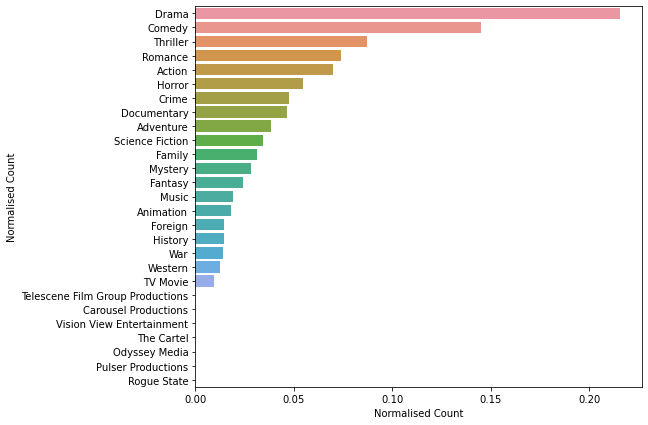

In [16]:
g = all_genres_df.nlargest(columns="Count", n=50) 
plt.figure(figsize=(8, 7)) 
ax = sns.barplot(data=g, x= "Normalised Count", y = "Genre") 
ax.set(ylabel = 'Normalised Count') 
plt.show()

We see that the last 7 genres do not fall under any specific category so we will replace them with "Other".

In [17]:
unknown_genres = ['Carousel Productions',
                  'Vision View Entertainment',
                  'Telescene Film Group Productions',
                  'Odyssey Media',
                  'Pulser Productions',
                  'Rogue State',
                  'The Cartel']

Let's loop though all our entries and remove these genres since their count is too small.

In [18]:
def remove_genres(row):
    '''
    Loops through all genres for each film and replaces with "Other"
    if genre is in the unknown_genres list.
    '''
    new_items = [x for x in row if x not in unknown_genres]
    
    return new_items

# Remove unknown genres from dataset
movie_data['genres'] = movie_data['genres'].apply(lambda x: remove_genres(x))  
# Reset df index
movie_data.reset_index(drop=True, inplace=True)

In [19]:
# Create a list of all the available genres
all_genres = [item for sublist in movie_data['genres'].values for item in sublist]
unique_genres = len(set(all_genres))
print("There are {} unique genres in the dataset.".format(unique_genres))

# Get the term frequencies
all_genres = nltk.FreqDist(all_genres)
# Create a DataFrame for plotting
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})
# Before we plot let's normalise the results by the total number of movies
all_genres_df['Normalised Count'] = all_genres_df['Count'] / all_genres_df['Count'].sum()

There are 20 unique genres in the dataset.


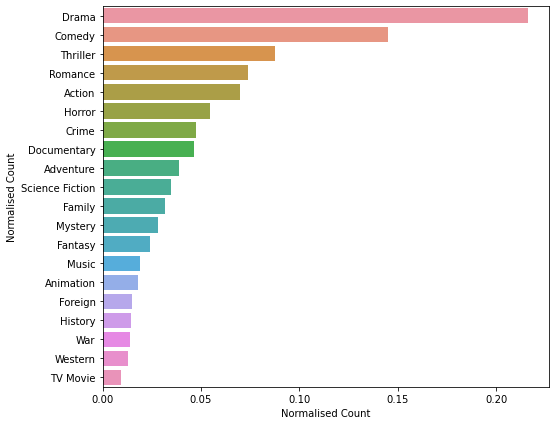

In [20]:
g = all_genres_df.nlargest(columns="Count", n=50) 
plt.figure(figsize=(8, 7)) 
ax = sns.barplot(data=g, x= "Normalised Count", y = "Genre") 
ax.set(ylabel = 'Normalised Count') 
plt.show()

The distribution of genres is skewed so when splitting the data for training we will try to stratify the dataset and potentially oversample the minority classes.

#### Text pre-processing

Before we train any models we will need to pre-process our text. <br>
We will follow these steps:
- Join the movie title to the movie description
- Remove whitespace, slashes, non-alphabetic charactes and convert text to lowecase
- Lemmatise the words
- Remove any stopwords

In [21]:
movie_data['text'] = \
    movie_data[['title', 'description']].apply(
        lambda row: tp.transform_text(row['title'], row['description']), axis=1)    

# Model training

### 1. Problem statement

This is a multi-label classification problem.

### 2. Features & Labels

First we need to one-hot encode our labels.

In [22]:
# Labels
multilabel_binarizer = MultiLabelBinarizer()  # Create a multi-class binariser
y = multilabel_binarizer.fit_transform(movie_data['genres'])  # Fit the binariser to the data and transform

# Features
X = movie_data['text']

# Split data to train and test set
X_train, X_test, y_train, y_test = \
    train_test_split(X.values, y, test_size=0.20, random_state=42)

### 3. Train Model

**Pipeline** <br>
We will use the pipeline utility from scikit learn to then be able to apply the same vectoriser to the new data. <br>
**Vectorizer** <br>
We will use a TfidfVectorizer to convert a collection of raw documents to a matrix of TF-IDF features. <br>
**OneVsRest multi-label strategy** <br>
The Multi-label algorithm accepts a binary mask over multiple labels.  <br>
The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample. <br>
**Estimator** <br>
There are multiple different estimators that we can use including, Logistic Regression, Naive Bayes, LinearSVC. <br>
All these estimators, support multi-class, but we are in a multi-label scenario, therefore, we need to wrap them in the OneVsRestClassifier. <br>
**Optimisation Metric** <br>
We will optimise the models for f1-score since we seek a balance between Precision and Recall *and* there is an uneven class distribution.

In [65]:
# Instantiate a TF-IDF vecrtorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

# Estimators to experiment
lr = LogisticRegression(solver='saga')
nb = MultinomialNB(fit_prior=True, class_prior=None)
svc = SVC(kernel='linear', probability=True, gamma='auto')
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()

# List of estimators to try
estimators = [lr]

# Create a list of pipelines to train
pipelines = [Pipeline([('Vectorizer', tfidf_vectorizer),
                       ('Classifier', OneVsRestClassifier(estimator))]) for estimator in estimators]

# Set of parameters to optimise for
parameters_lr = {}
parameters_nb = {}
parameters_svc = {}
parameters_rf = {}

# Create a list of parameters to optimise for each estimator
parameters_list=[parameters_lr, parameters_nb]

Train classifiers and get the best model:

In [66]:
for i in range(len(pipelines)):
    # We will use 3-fold cross-validation
    Grid = GridSearchCV(estimator=pipelines[i], param_grid=parameters_list[i], 
                        n_jobs=-1, cv=3, verbose=0, scoring='f1_micro').fit(X_train, y_train)

In [67]:
Grid.best_estimator_

Pipeline(steps=[('Vectorizer', TfidfVectorizer(max_df=0.8, max_features=10000)),
                ('Classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(solver='saga')))])

In [68]:
Grid.cv_results_

{'mean_fit_time': array([8.83147629]),
 'std_fit_time': array([0.01392807]),
 'mean_score_time': array([0.46032691]),
 'std_score_time': array([0.08894106]),
 'params': [{}],
 'split0_test_score': array([0.441045]),
 'split1_test_score': array([0.44534601]),
 'split2_test_score': array([0.44037722]),
 'mean_test_score': array([0.44225608]),
 'std_test_score': array([0.00220186]),
 'rank_test_score': array([1])}

In [70]:
best_pipeline = Grid.best_estimator_
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Vectorizer', TfidfVectorizer(max_df=0.8, max_features=10000)),
                ('Classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(solver='saga')))])

In [71]:
# make predictions for validation set
y_pred_test = best_pipeline.predict(X_test)

In [72]:
# evaluate performance
f1_score(y_test, y_pred_test, average="micro")

0.47527600355314914

In [165]:
title = 'Avengers'
plot = "After the devastating events of Avengers: Infinity War (2018), the universe is in ruins. With the help of remaining allies, the Avengers assemble once more in order to reverse Thanos' actions and restore balance to the universe."

processed_data = tp.transform_text(title, plot)
print(processed_data)

avenger devastating event avenger infinity war universe ruin help remaining ally avenger assemble order reverse thanos action restore balance universe


In [166]:
probabilities = best_pipeline.predict_proba([processed_data])
probabilities_df = pd.DataFrame(probabilities, index=['Probabilities'], columns=multilabel_binarizer.classes_).T
probabilities_df.sort_values(by='Probabilities', ascending=False)

,Probabilities
Action,0.499433
Science Fiction,0.308687
Comedy,0.281046
Drama,0.227296
Adventure,0.206122
Thriller,0.105127
Romance,0.087649
Animation,0.083569
Fantasy,0.079167
History,0.056201


In [75]:
threshold = 0.5
top_genres = np.where(probabilities > threshold, 1, 0)

In [76]:
multilabel_binarizer.classes_[top_genres[0] > 0]

array(['Action', 'Science Fiction'], dtype=object)

In [77]:
probabilities = best_pipeline.predict_proba(X_test)

scores, accuracy = {}, {}
for threshold in np.arange(0.0, 1.1, 0.1):
    # make predictions for validation set
    top_genres = np.where(probabilities > threshold, 1, 0)
    # evaluate performance
    accuracy[threshold] = accuracy_score(y_test, top_genres)
    scores[threshold] = f1_score(y_test, top_genres, average="micro")

In [78]:
model_accuracy = pd.DataFrame(data=accuracy.items(), index= accuracy.keys(), columns=['Threshold', 'Accuracy'])
model_f1_score = pd.DataFrame(data=scores.items(), index= scores.keys(), columns=['Threshold', 'F1-Score'])

<AxesSubplot:xlabel='Threshold'>

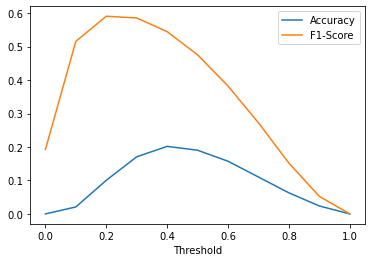

In [79]:
pd.merge(model_accuracy, model_f1_score, on='Threshold').set_index('Threshold').plot()

Select a threshold for the model:

In [82]:
threshold = 0.4

Export model to pickle

In [83]:
model_filename = "./movie_classifier_trained_model.pkl"  

with open(model_filename, 'wb') as filename:  
    joblib.dump({'pipeline': best_pipeline, 'genres': multilabel_binarizer.classes_, 'threshold': threshold}, model_filename)

In [148]:
probabilities

array([[0.88998973, 0.43849508, 0.24151986, 0.48812803, 0.01002413,
        0.00925152, 0.04141633, 0.21056366, 0.1451008 , 0.01390061,
        0.01396861, 0.12127438, 0.0124842 , 0.01371872, 0.03854378,
        0.92241737, 0.01488592, 0.06553251, 0.06525369, 0.01773004]])

In [86]:
np.where(probabilities >= threshold, 1, 0)

array([[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

In [91]:
multilabel_binarizer.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
       'TV Movie', 'Thriller', 'War', 'Western'], dtype=object)

In [150]:
sorted_index = (-probabilities).argsort()
sorted_index

array([[15,  0,  3,  1,  2,  7,  8, 11, 17, 18,  6, 14, 19, 16, 10,  9,
        13, 12,  4,  5]], dtype=int64)

In [156]:
probabilities_sorted = probabilities[0][sorted_index[::-1]]

In [154]:
sorted_arr1 = multilabel_binarizer.classes_[sorted_index[::-1]]

In [155]:
sorted_arr1

array([['Science Fiction', 'Action', 'Comedy', 'Adventure', 'Animation',
        'Family', 'Fantasy', 'Horror', 'Thriller', 'War', 'Drama',
        'Romance', 'Western', 'TV Movie', 'History', 'Foreign',
        'Mystery', 'Music', 'Crime', 'Documentary']], dtype=object)

In [157]:
top_genres = np.where(probabilities_sorted >= threshold, 1, 0)  # Genres with prob > threshold


In [158]:
top_genres

array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [161]:
sorted_genres = multilabel_binarizer.classes_[sorted_index[::-1]]

In [163]:
sorted_genres

array([['Science Fiction', 'Action', 'Comedy', 'Adventure', 'Animation',
        'Family', 'Fantasy', 'Horror', 'Thriller', 'War', 'Drama',
        'Romance', 'Western', 'TV Movie', 'History', 'Foreign',
        'Mystery', 'Music', 'Crime', 'Documentary']], dtype=object)

In [164]:
sorted_genres[0][top_genres[0] > 0]

array(['Science Fiction', 'Action', 'Comedy', 'Adventure'], dtype=object)